In [5]:
# notebooks/RandomForest.ipynb

## Import necessary libraries
import sys
sys.path.append('../scripts')

from mongo_connection import get_matches_collection
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

Data Preparation

In [6]:
# Fetch data from MongoDB
collection = get_matches_collection()
cursor = collection.find({})

In [7]:
# Convert MongoDB cursor to DataFrame
df = pd.DataFrame(list(cursor))

# Show the first few rows of the DataFrame
df.head()

,_id,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,winner
0,6692ad7288365a953ad9e564,1879-04-07,Wales,Scotland,0,3,Friendly,Wrexham,Wales,False,Scotland
1,6692ad7288365a953ad9e565,1880-03-13,Scotland,England,5,4,Friendly,Glasgow,Scotland,False,Scotland
2,6692ad7288365a953ad9e559,1873-03-08,England,Scotland,4,2,Friendly,London,England,False,England
3,6692ad7288365a953ad9e558,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False,Draw
4,6692ad7288365a953ad9e566,1880-03-15,Wales,England,2,3,Friendly,Wrexham,Wales,False,England


In [8]:
# Feature engineering
df['winner'] = df.apply(lambda row: 'Draw' if row['home_score'] == row['away_score'] else (row['home_team'] if row['home_score'] > row['away_score'] else row['away_team']), axis=1)

# Converting categorical columns to numerical (one-hot encoded)
df = pd.get_dummies(df, columns=['home_team', 'away_team', 'tournament', 'city', 'country', 'winner'], drop_first=True)

# Defining features and target variable
features = df.drop(columns=['_id', 'date', 'home_score', 'away_score', 'winner_Draw', 'winner_England', 'winner_Scotland'])
target = df['winner_Draw'] 

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

Model Training

In [9]:
## Step 2: Model Training

# Initialize Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

In [10]:
## Step 3: Model Evaluation

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.9790017938166087
Classification Report:
               precision    recall  f1-score   support

       False       0.99      0.99      0.99      7256
        True       0.95      0.96      0.96      2221

    accuracy                           0.98      9477
   macro avg       0.97      0.97      0.97      9477
weighted avg       0.98      0.98      0.98      9477

Confusion Matrix:
 [[7153  103]
 [  96 2125]]


Saving the Model

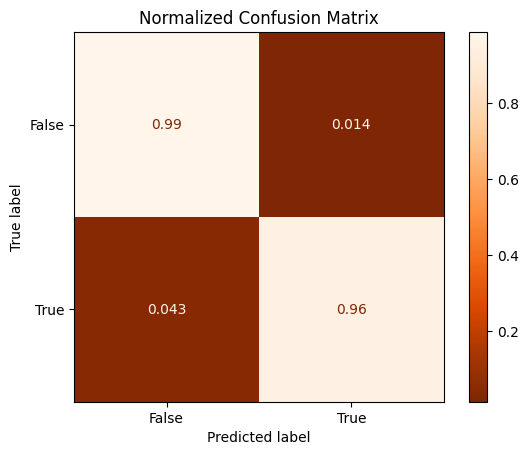

In [21]:
# Improved Confusion Matrix Visualization
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Oranges_r', normalize='true')
plt.title('Normalized Confusion Matrix')
plt.show()


In [12]:
# Plot Feature Importances
feature_importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': features.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

C:\Users\HP\AppData\Local\Temp\ipykernel_5356\22005472.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=sorted_importances, palette='viridis')


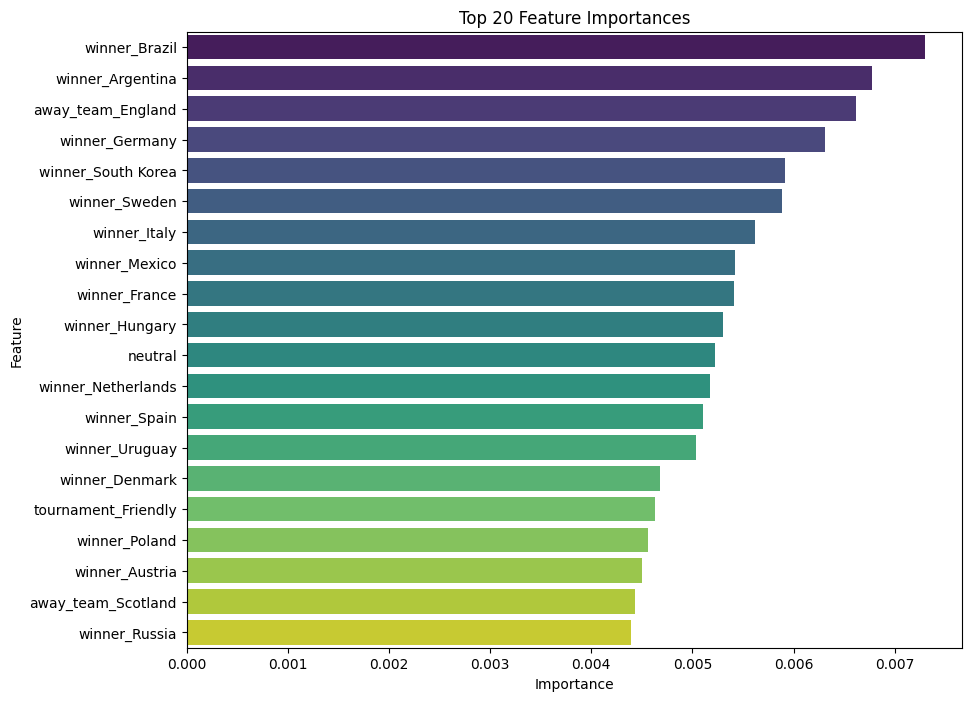

In [22]:
# Improved Feature Importance Visualization
top_n = 20  # Number of top features to display
sorted_importances = feature_importance_df.head(top_n)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=sorted_importances, palette='viridis')
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [14]:
# Calculate and Plot ROC Curve
y_prob = rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)

C:\Users\HP\AppData\Local\Temp\ipykernel_5356\2562445602.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='gray')  # Diagonal line


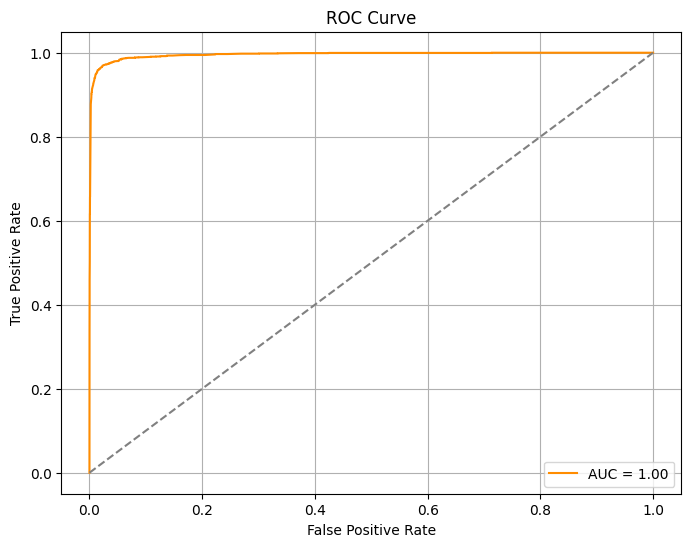

In [24]:
# Improved ROC Curve Visualization
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', color='gray')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


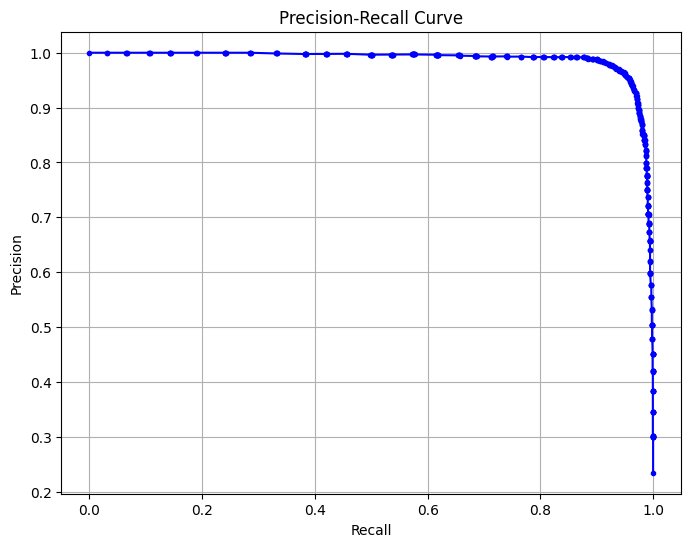

In [26]:
# Improved Precision-Recall Curve Visualization
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()


In [17]:
# Perform Cross-Validation
cv_scores = cross_val_score(rf_model, features, target, cv=5, scoring='accuracy')
print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Accuracy:", np.mean(cv_scores))

Cross-Validation Scores: [0.95705392 0.98068805 0.98300971 0.97382862 0.95198396]
Mean Cross-Validation Accuracy: 0.9693128523866607


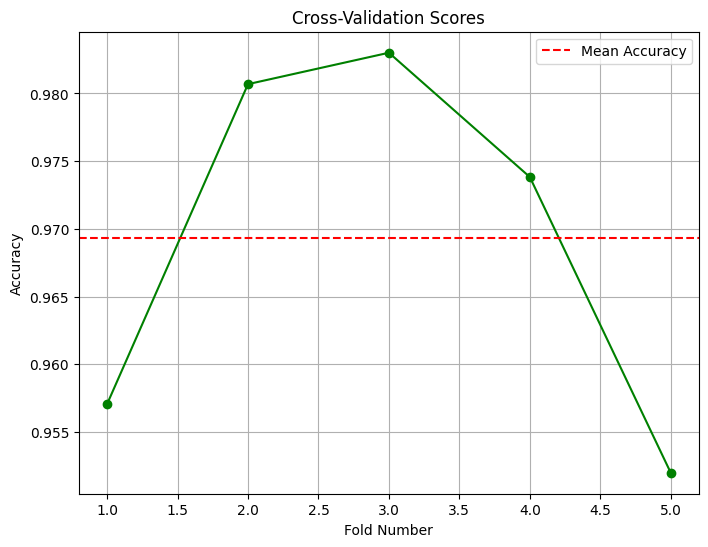

In [27]:
# Visualize Cross-Validation Results
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cv_scores) + 1), cv_scores, marker='o', linestyle='-', color='green')
plt.axhline(y=np.mean(cv_scores), color='red', linestyle='--', label='Mean Accuracy')
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.title('Cross-Validation Scores')
plt.legend()
plt.grid(True)
plt.show()


In [18]:
## Step 4: Model Persistence

# Save the trained model to a file
joblib.dump(rf_model, '../models/random_forest_model.pkl')

# Load the trained model from the file
loaded_rf_model = joblib.load('../models/random_forest_model.pkl')